In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The data we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("data/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploration

In [4]:
df.shape

(284807, 31)

Let's check for missing values:

In [5]:
df.isnull().values.any()

False

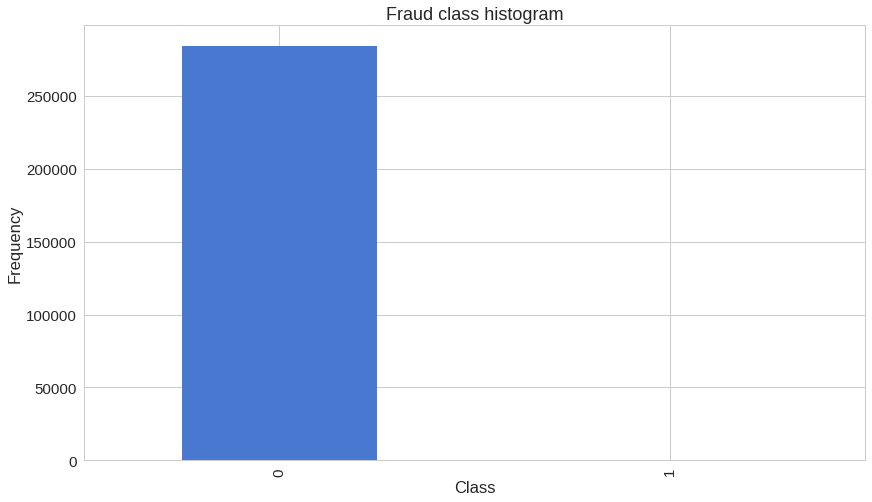

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency");

If the Class = 1 -> fraud

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [8]:
frauds.shape

(492, 31)

In [9]:
normal.shape

(284315, 31)

We have highly imbalanced dataset.

In [10]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

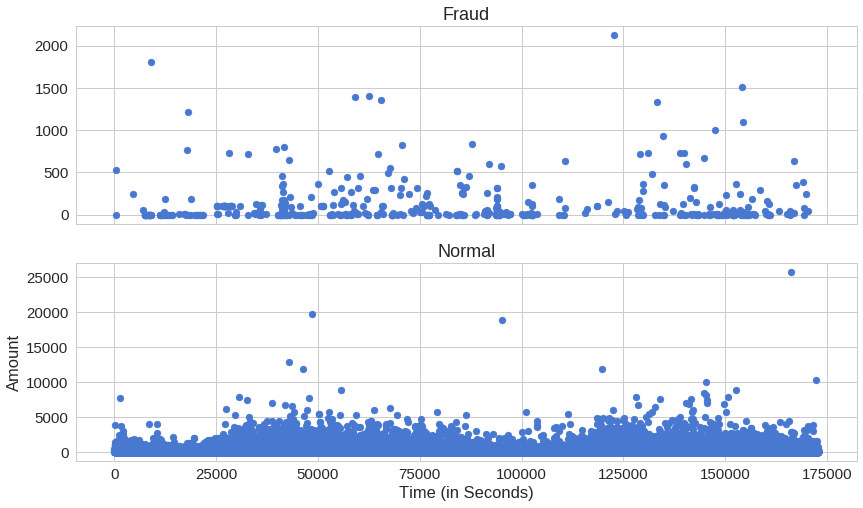

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

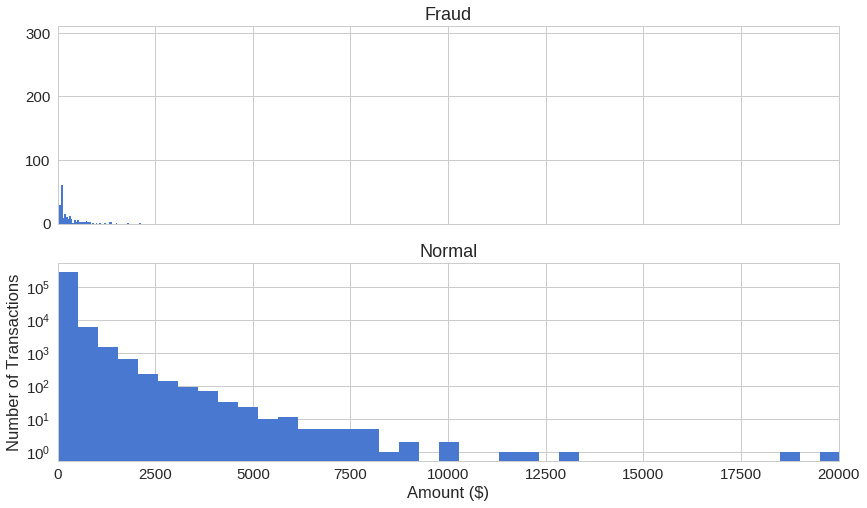

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

# Preparing the data

In [14]:
len(df.columns)

31

In [15]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [16]:
data.shape

(284807, 30)

In [17]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [18]:
X_train.shape

(227845, 29)

# Building the model

In [19]:
batch_size = 32
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100

In [20]:
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
# encoded = Dense(encoding_dim, activation='tanh' )(input_img)

encoded = Dense(encoding_dim, activation='tanh', 
                activity_regularizer=regularizers.l1(10e-5))(input_img)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# encoded = Dense(encoding_dim, activation='relu' )(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(int(input_dim / 2), activation='tanh')(encoded)
# decoded = Dense(int(input_dim / 2), activation='relu')(decoded)
decoded = Dense(input_dim, activation='relu')(decoded)
# decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [21]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                   epochs=nb_epoch,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(X_test, X_test), callbacks=[checkpointer, tensorboard]).history

Train on 227845 samples, validate on 56962 samples
Epoch 1/100
227845/227845 [==============================] - 30s - loss: 0.8331 - acc: 0.6197 - val_loss: 0.7643 - val_acc: 0.6610
Epoch 2/100
227845/227845 [==============================] - 22s - loss: 0.7719 - acc: 0.6657 - val_loss: 0.7554 - val_acc: 0.6627
Epoch 3/100
227845/227845 [==============================] - 21s - loss: 0.7635 - acc: 0.6708 - val_loss: 0.7480 - val_acc: 0.6705
Epoch 4/100
227845/227845 [==============================] - 20s - loss: 0.7589 - acc: 0.6734 - val_loss: 0.7504 - val_acc: 0.6708
Epoch 5/100
227845/227845 [==============================] - 20s - loss: 0.7558 - acc: 0.6768 - val_loss: 0.7428 - val_acc: 0.6914
Epoch 6/100
227845/227845 [==============================] - 21s - loss: 0.7529 - acc: 0.6812 - val_loss: 0.7399 - val_acc: 0.6804
Epoch 7/100
227845/227845 [==============================] - 21s - loss: 0.7504 - acc: 0.6833 - val_loss: 0.7372 - val_acc: 0.6884
Epoch 8/100
227845/227845 [=====

227845/227845 [==============================] - 21s - loss: 0.7263 - acc: 0.7164 - val_loss: 0.7181 - val_acc: 0.7072
Epoch 63/100
227845/227845 [==============================] - 21s - loss: 0.7271 - acc: 0.7162 - val_loss: 0.7136 - val_acc: 0.7236
Epoch 64/100
227845/227845 [==============================] - 22s - loss: 0.7270 - acc: 0.7169 - val_loss: 0.7215 - val_acc: 0.7175
Epoch 65/100
227845/227845 [==============================] - 21s - loss: 0.7269 - acc: 0.7162 - val_loss: 0.7165 - val_acc: 0.7198
Epoch 66/100
227845/227845 [==============================] - 23s - loss: 0.7267 - acc: 0.7174 - val_loss: 0.7188 - val_acc: 0.7199
Epoch 67/100
227845/227845 [==============================] - 21s - loss: 0.7269 - acc: 0.7169 - val_loss: 0.7203 - val_acc: 0.7095
Epoch 68/100
227845/227845 [==============================] - 21s - loss: 0.7273 - acc: 0.7180 - val_loss: 0.7161 - val_acc: 0.7204
Epoch 69/100
227845/227845 [==============================] - 21s - loss: 0.7268 - acc: 0

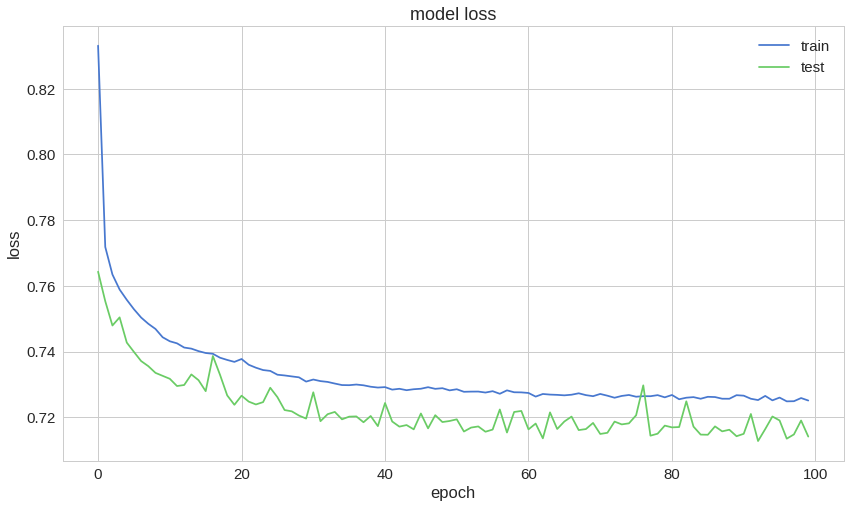

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [23]:
predictions = autoencoder.predict(X_test)

In [24]:
predictions.shape

(56962, 29)

In [25]:
def get_df(test_data, predictions, truth_labels):
    mse = np.mean(np.power(test_data - predictions, 2), axis=1)
    return pd.DataFrame({'reconstruction_error': mse, 'true_class': truth_labels})

In [26]:
res_df = get_df(X_test, predictions, y_test)

In [27]:
res_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.707764,0.001720
std,3.245561,0.041443
min,0.037785,0.000000
25%,0.235990,0.000000
50%,0.376867,0.000000
75%,0.594544,0.000000
max,247.100783,1.000000


## Reconstruction error w/o fraud

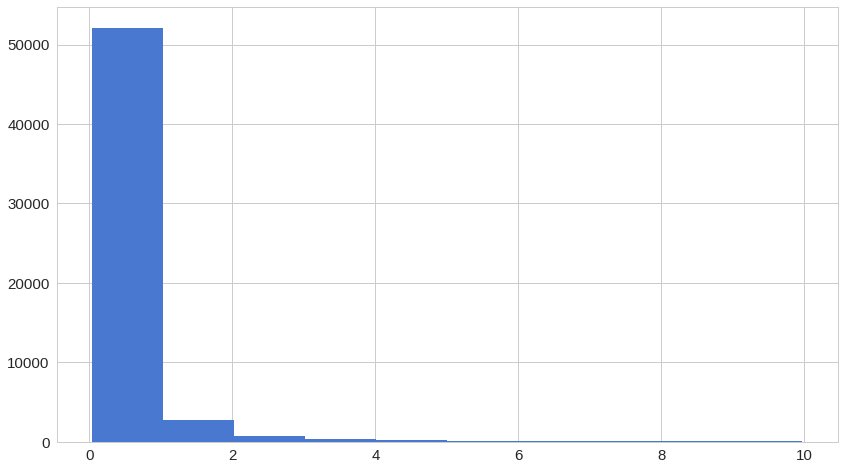

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(res_df[(res_df['true_class']== 0) & (res_df['reconstruction_error'] < 10)].reconstruction_error.values, bins=10)

## Reconstruction error with fraud

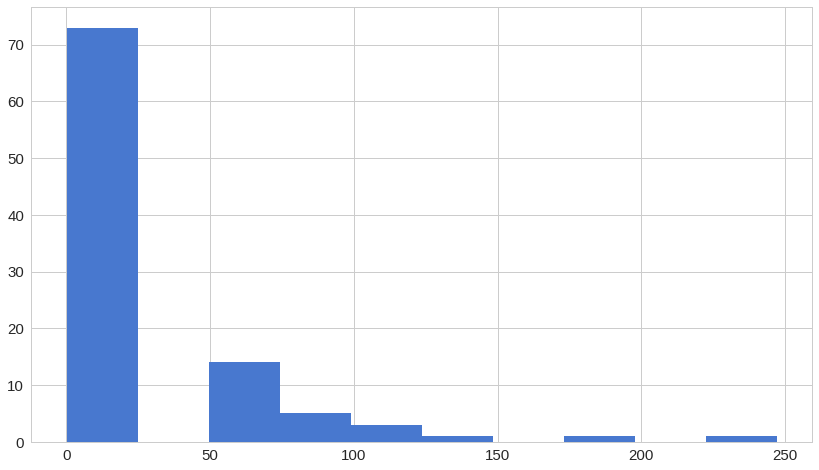

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(res_df[res_df['true_class'] > 0].reconstruction_error.values, bins=10)

In [30]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

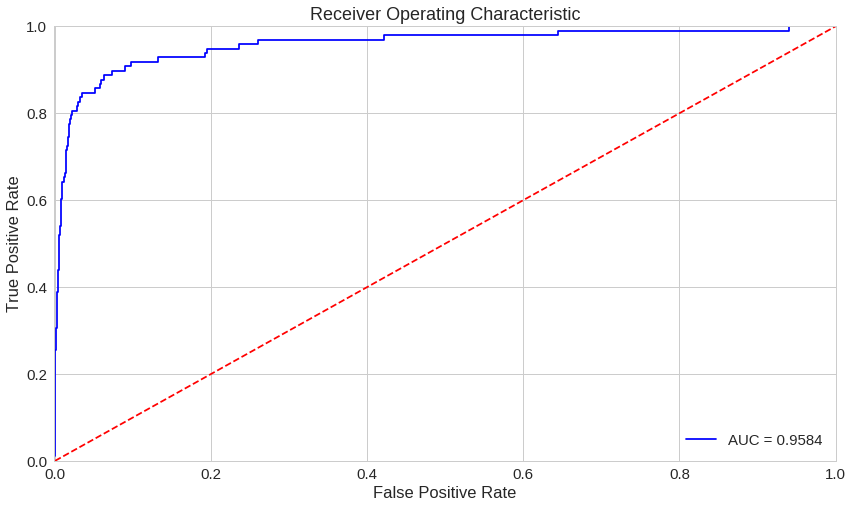

In [31]:
fpr, tpr, thresholds = roc_curve(res_df.true_class, res_df.reconstruction_error)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

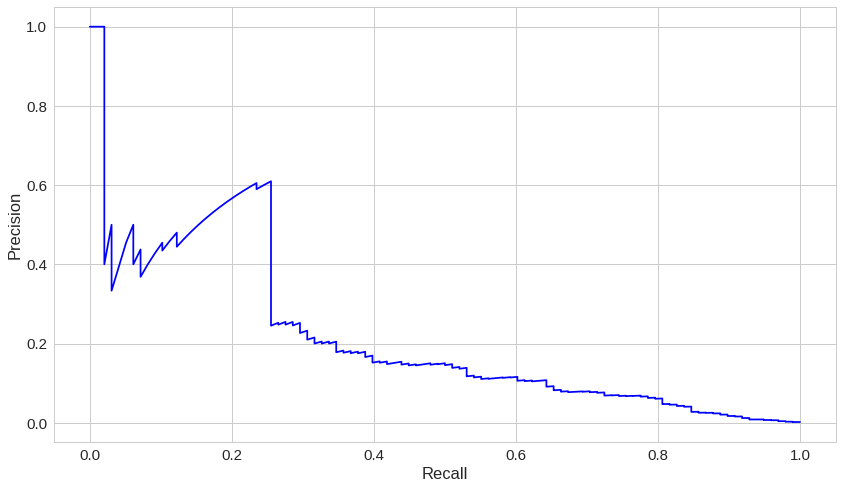

In [32]:
precision, recall, th = precision_recall_curve(res_df.true_class, res_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

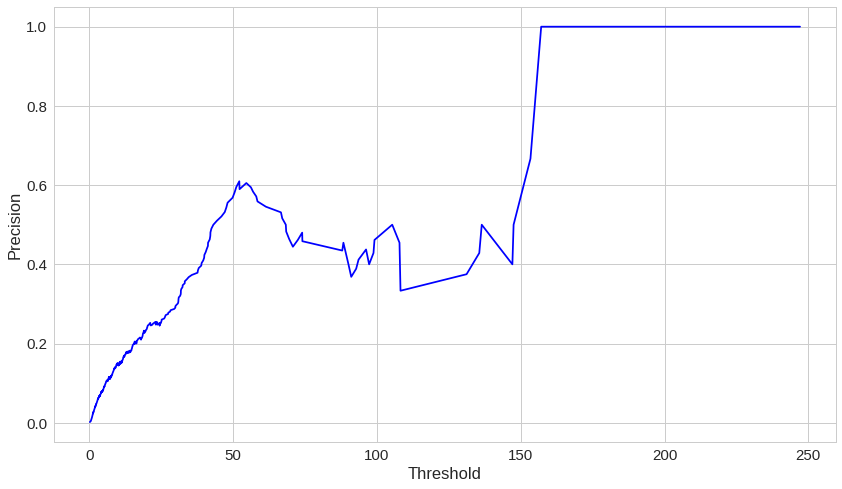

In [33]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [ ]:
cutoff = 2.7

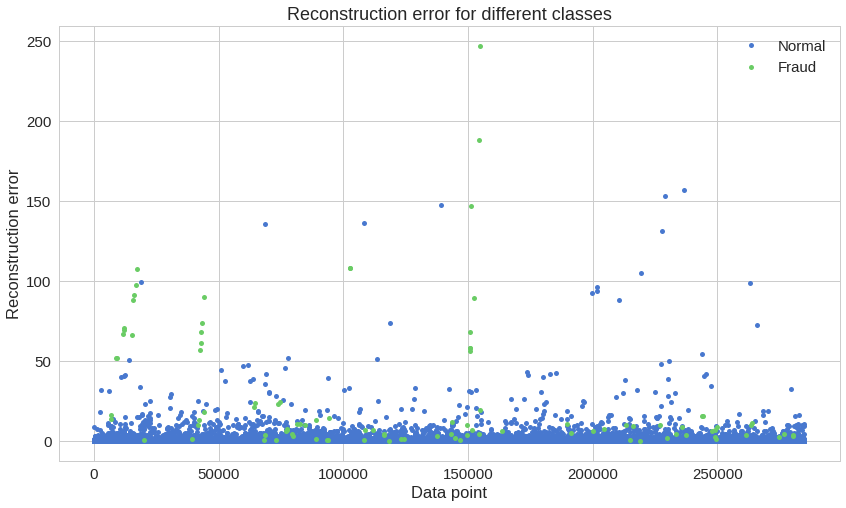

In [89]:
groups = res_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.legend()
ax.hlines(cutoff, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point")
plt.show();

In [42]:
y_pred = [1 if e > cutoff else 0 for e in res_df.reconstruction_error.values]
conf_matrix = confusion_matrix(res_df.true_class, y_pred)

print("Recall metric in the testing dataset: ", float(conf_matrix[1,1])/(conf_matrix[1,0]+conf_matrix[1,1]))

Recall metric in the testing dataset:  0.80612244898


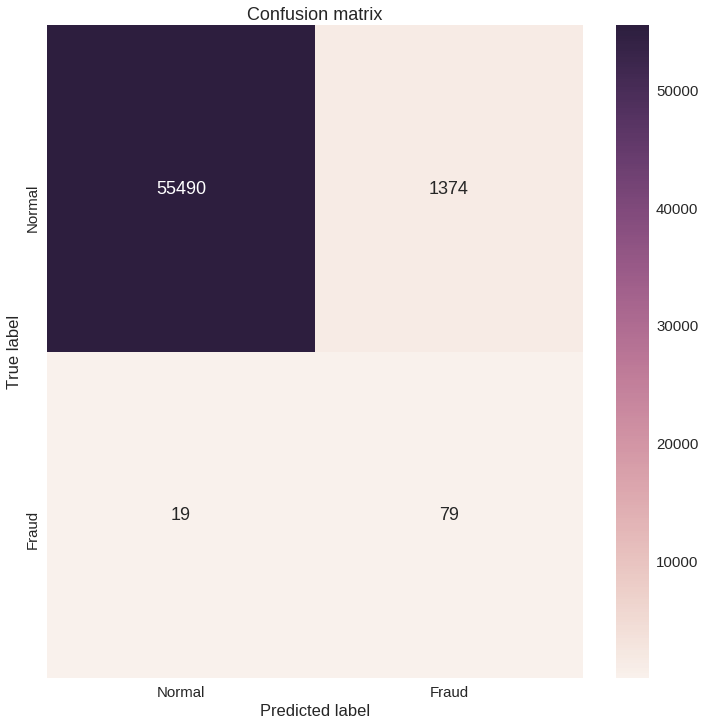

In [43]:
width = 12
height = 12
plt.figure(figsize=(width, height))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()